In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
import glob
# import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import cifar10


import numpy as np
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils.layer_utils import get_source_inputs
from keras.utils.vis_utils import plot_model

In [19]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()
assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert Y_train.shape == (50000, 1)
assert Y_test.shape == (10000, 1)
label_name=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [20]:
print('X_train.shape  :', X_train.shape)
print('Y_train.shape  :', Y_train.shape)
print('X_test.shape   :', X_test.shape)
print('Y_test.shape   :', Y_test.shape)

X_train.shape  : (50000, 32, 32, 3)
Y_train.shape  : (50000, 1)
X_test.shape   : (10000, 32, 32, 3)
Y_test.shape   : (10000, 1)


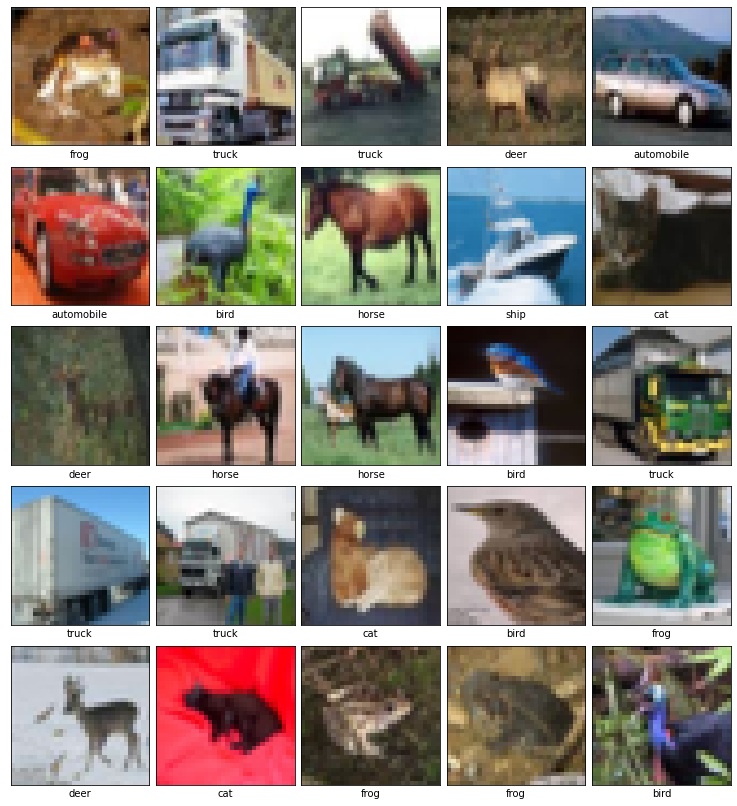

In [21]:
fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1.1, hspace=0.05, wspace=0.05)

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.set(xlabel=label_name[Y_train[i][0]])


In [22]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
   
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def ResNet50_Model():
    

    img_input = Input(shape=(32, 32, 3),name="input_2")

    x = Conv2D(256, (7, 7), name='conv1')(img_input)
    x = BatchNormalization( name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    print(x)
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    print(x)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = GlobalAveragePooling2D()(x)

    x = Flatten()(x)
    x = Dense(10, activation='softmax', name='fc1000')(x)

    model = Model(img_input, x, name='resnet50')

    return model



In [23]:
model = ResNet50_Model()
layer_names = [layer.name for layer in model.layers]
plot_model(model, to_file="my_model.png", show_shapes=True)
# model.summary()

Output hidden; open in https://colab.research.google.com to view.

In [24]:
epochs=100
batch_size=128
learning_rate=0.0001

opt = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt ,metrics=['accuracy'])

#	t = now()
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=.3)
(loss, accuracy) = model.evaluate(X_test, Y_test, batch_size=batch_size)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Epoch 1/100
274/274 [==============================] - 48s 155ms/step - loss: 2.1112 - accuracy: 0.2498 - val_loss: 2.1418 - val_accuracy: 0.2409
Epoch 2/100
274/274 [==============================] - 41s 148ms/step - loss: 1.7383 - accuracy: 0.3731 - val_loss: 2.0049 - val_accuracy: 0.3395
Epoch 3/100
274/274 [==============================] - 40s 146ms/step - loss: 1.5742 - accuracy: 0.4331 - val_loss: 1.8776 - val_accuracy: 0.3859
Epoch 4/100
274/274 [==============================] - 40s 148ms/step - loss: 1.4182 - accuracy: 0.4901 - val_loss: 1.9855 - val_accuracy: 0.3864
Epoch 5/100
274/274 [==============================] - 40s 147ms/step - loss: 1.2948 - accuracy: 0.5359 - val_loss: 1.6751 - val_accuracy: 0.4357
Epoch 6/100
274/274 [==============================] - 40s 147ms/step - loss: 1.1648 - accuracy: 0.5864 - val_loss: 1.6950 - val_accuracy: 0.4526
Epoch 7/100
274/274 [==============================] - 40s 147ms/step - loss: 1.0187 - accuracy: 0.6371 - val_loss: 1.5888 -

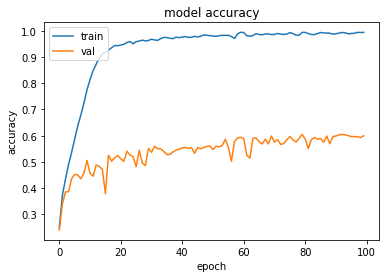

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

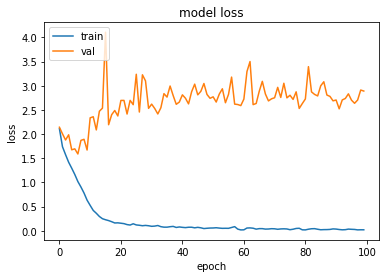

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()